In [3]:
%pip install numpy pandas matplotlib networkx


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random

# Set seed for reproducibility during testing (optional)
# np.random.seed(42)



In [19]:
# --- Task (a): Define HMM parameters using suitable data structures ---
def get_hmm_parameters():
    """
    Returns the define states, observations, and probability matrices.
    """
    # Hidden States (Phonemes)
    states = ['/s/', '/p/', '/i:/', '/tS/']
    n_states = len(states)

    # Observations (Acoustic Properties)
    observations = ['Energy', 'Pitch', 'Duration']
    n_obs = len(observations)

    # 1. Initial Probabilities (pi)
    pi = np.array([1.0, 0.0, 0.0, 0.0])

    # 2. Transition Probabilities (A Matrix)
    # Rows=From State, Cols=To State
    transition_matrix = np.array([
        [0.3,  0.7,  0.0,  0.0],  # From /s/
        [0.0,  0.2,  0.8,  0.0],  # From /p/
        [0.0,  0.0,  0.4,  0.6],  # From /i:/
        [0.0,  0.0,  0.0,  1.0]   # From /tS/ (Absorbing state)
    ])

    # 3. Emission Probabilities (B Matrix)
    # Rows=Phoneme State, Cols=Observation
    # Energy Pitch Duration
    emission_matrix = np.array([
        [0.7,    0.2,   0.1],     # /s/
        [0.5,    0.3,   0.2],     # /p/
        [0.3,    0.5,   0.2],     # /i:/
        [0.4,    0.4,   0.2]      # /tS/
    ])

    return states, observations, pi, transition_matrix, emission_matrix


In [20]:

# --- Task (b): Function to neatly display parameters ---
def display_parameters(states, observations, pi, trans_mat, emit_mat):
    print("--- HMM Parameters for word 'speech' ---")
    
    print("\n1. Initial Probabilities (π):")
    df_pi = pd.DataFrame(pi.reshape(1, -1), columns=states, index=["Prob"])
    print(df_pi.to_string())

    print("\n2. Transition Probability Matrix (A):")
    print("(Rows=From State, Cols=To State)")
    df_trans = pd.DataFrame(trans_mat, columns=states, index=states)
    print(df_trans.to_string())

    print("\n3. Emission Probability Matrix (B):")
    print("(Rows=Phoneme State, Cols=Observation)")
    df_emit = pd.DataFrame(emit_mat, columns=observations, index=states)
    print(df_emit.to_string())
    print("-" * 40 + "\n")


In [21]:

# --- Task (c): Program to generate a single sequence ---
def simulate_sequence(states, observations, pi, trans_mat, emit_mat, max_length=10):
    """
    Generates sequences based on defined probabilities inputs.
    """
    n_states = len(states)
    n_obs = len(observations)
    generated_states = []
    generated_observations = []

    # 1. Determine Initial State
    current_state_idx = np.random.choice(range(n_states), p=pi)
    
    for _ in range(max_length):
        current_state_name = states[current_state_idx]
        generated_states.append(current_state_name)

        # 2. Generate Observation (Emission)
        obs_probs = emit_mat[current_state_idx]
        obs_idx = np.random.choice(range(n_obs), p=obs_probs)
        generated_observations.append(observations[obs_idx])

        # 3. Determine Next State (Transition)
        trans_probs = trans_mat[current_state_idx]
        next_state_idx = np.random.choice(range(n_states), p=trans_probs)

        # Stopping condition: if absorbing state '/tS/' transitions to itself.
        if current_state_idx == (n_states - 1) and next_state_idx == current_state_idx:
            break
            
        current_state_idx = next_state_idx

    return generated_states, generated_observations


--- HMM Parameters for word 'speech' ---

1. Initial Probabilities (π):
      /s/  /p/  /i:/  /tS/
Prob  1.0  0.0   0.0   0.0

2. Transition Probability Matrix (A):
(Rows=From State, Cols=To State)
      /s/  /p/  /i:/  /tS/
/s/   0.3  0.7   0.0   0.0
/p/   0.0  0.2   0.8   0.0
/i:/  0.0  0.0   0.4   0.6
/tS/  0.0  0.0   0.0   1.0

3. Emission Probability Matrix (B):
(Rows=Phoneme State, Cols=Observation)
      Energy  Pitch  Duration
/s/      0.7    0.2       0.1
/p/      0.5    0.3       0.2
/i:/     0.3    0.5       0.2
/tS/     0.4    0.4       0.2
----------------------------------------

--- Generating Sequence ---
Generated phoneme sequence: ['/s/', '/s/', '/p/', '/p/', '/i:/', '/i:/', '/tS/']
Corresponding observations: ['Energy', 'Energy', 'Duration', 'Pitch', 'Energy', 'Pitch', 'Energy']

Generating visualization...


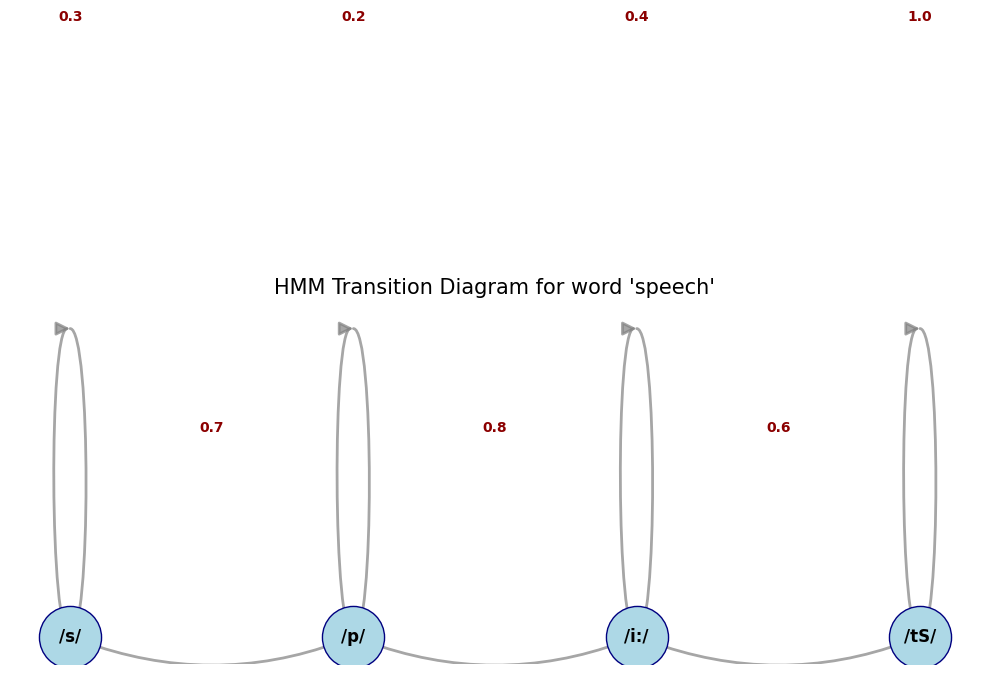

In [22]:
# --- Visualization Function ---
def visualize_hmm_transitions(states, trans_mat):
    G = nx.MultiDiGraph() 

    # Layout positions for left-to-right flow
    pos = {'/s/': (0, 0), '/p/': (1, 0), '/i:/': (2, 0), '/tS/': (3, 0)}

    for state in states:
        G.add_node(state)

    for i, origin_state in enumerate(states):
        for j, target_state in enumerate(states):
            weight = trans_mat[i][j]
            if weight > 0:
                G.add_edge(origin_state, target_state, weight=weight)

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', edgecolors='navy')
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # Draw curved edges
    for (u, v, d) in G.edges(data=True):
        style = f'arc3, rad={0.2}' if u != v else f'arc3, rad={0.5}'
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, alpha=0.7, 
                               edge_color='gray', connectionstyle=style, arrowsize=20)
        
        # Label placement logic for curves
        if u == v: label_x, label_y = pos[u][0], pos[u][1] + 0.3
        else:      label_x, label_y = (pos[u][0]+pos[v][0])/2, (pos[u][1]+pos[v][1])/2 + 0.1
            
        plt.text(label_x, label_y, f"{d['weight']:.1f}", 
                 ha='center', color='darkred', fontsize=10, fontweight='bold')

    plt.title("HMM Transition Diagram for word 'speech'", fontsize=15)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Main Execution flow ---
if __name__ == "__main__":
    # 1. Get Data Structures
    states_data, obs_data, pi_data, A_matrix, B_matrix = get_hmm_parameters()

    # 2. Display Parameters (Task b)
    display_parameters(states_data, obs_data, pi_data, A_matrix, B_matrix)

    # 3. Generate Sequence (Task c)
    print("--- Generating Sequence ---")
    gen_states, gen_obs = simulate_sequence(states_data, obs_data, pi_data, A_matrix, B_matrix)
    
    # Formatting output
    formatted_states = ["'" + s + "'" for s in gen_states]
    print(f"Generated phoneme sequence: [{', '.join(formatted_states)}]")
    print(f"Corresponding observations: {gen_obs}")

    # 4. Visualization
    print("\nGenerating visualization...")
    visualize_hmm_transitions(states_data, A_matrix)